In [184]:
import pandas as pd
import numpy as np
import os
from copy import deepcopy
import math

import matplotlib.pyplot as plt
import seaborn as sns

import pint
from pint import UnitRegistry

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from math import sqrt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [80]:
def to_CI(df):
    def celc(x):
        ureg = UnitRegistry()
        Q_ = ureg.Quantity
        home = Q_(x, ureg.degC)
        return home.to('degK')

    def ream(x):
        ureg = UnitRegistry()
        Q_ = ureg.Quantity
        home = Q_(x, ureg.degR)
        return home.to('degK')
    
    celc_features = ['ZT1AB', 'ZTNAC', 'ZTOIL', 'ZT1A', 'GEGTMC', 'ZTNAC_D']
    ream_features = ['ZTAMB']
    
    for cl in celc_features:
        if cl in df.columns.to_list():
            df[cl] = pd.Series(celc(df[cl].values))
            
    for cl in ream_features:
        if cl in df.columns.to_list():
            df[cl] = pd.Series(ream(df[cl].values))
    
    return df

def preprocess_file(df, corr_ther):
    def delete_corr(df, ther):
        was_corr = []
        corr = df.corr()
        for row in corr.iterrows():
            for v_ind in range(len(row[1])):
                if row[1][v_ind] > ther and row[1][v_ind] < 1: #ПЕРЕСЧИТАТЬ
                    if (row[0] not in was_corr) and (row[1].index[v_ind] not in was_corr):
                        print(row[0], row[1].index[v_ind], row[1][v_ind])
                        was_corr.append(row[0])
        print(len(was_corr))
        return was_corr
    #удалить лишние
    df = df.drop(['flight_datetime', 'engine_id'], axis = 1)
    
    #виды фичей
    to_categorical = ['number_blades', 'engine_position', 'engine_type', 
                  'manufacturer', 'aircraft_family', 'aircraft_type', 'aircraft_grp',
                  'ac_manufacturer', 'n1_modifier', 'IAI', 'ZVB2F', 'ZVB2R', 'IBE', 'IVS12', 'IAIE']
    numerical = list(set(df.columns.to_list()) - set(to_categorical))
    
    #убрать те у которых больше 2/3 пропущены значения
    for cl in numerical:
        if (cl in df.columns.to_list()) and (len(df[cl]) * 2 / 3 < df[cl].isna().sum()):
            df = df.drop([cl], axis = 1)
    #обновить список числовых фияей
    numerical = list(set(df.columns.to_list()) - set(to_categorical))
    #заполнить оставшиеся пропуски нулями
    df = df.fillna(0)
    
    #перевести в систему СИ
    df = to_CI(df)

    #убрать скоррелированные фичи
    was_corr = delete_corr(df[numerical], corr_ther)
    df.drop(was_corr, axis = 1)
    #обновить список числовых фияей
    numerical = list(set(df.columns.to_list()) - set(to_categorical))
    
    #скалировать данные
    scaled_features = StandardScaler().fit_transform(df[numerical].values)
    scaled_features_df = pd.DataFrame(scaled_features, index=df[numerical].index, columns=df[numerical].columns)
    
    scaled_features_df
    #исправить типы данных категориальных фичей
    for cl in to_categorical:
        if cl in df.columns.to_list():
            df[cl] = df[cl].astype(object)
            #One Hot Encoding
            one_hot = pd.get_dummies(df[cl])
            scaled_features_df = pd.concat([scaled_features_df,one_hot], axis=1)
    
    return scaled_features_df

In [81]:
df = pd.read_csv("../data/grouped/takeoff_CF34-8E.csv")
df.columns

Index(['engine_id', 'flight_datetime', 'engine_position', 'n1_modifier',
       'number_blades', 'engine_type', 'manufacturer', 'ZPCN12', 'ZPCN25',
       'ZPN12R', 'ZPOIL', 'ZPS3', 'ZT1AB', 'ZT3', 'ZT49', 'ZTAMB', 'ZTLA',
       'ZTOIL', 'ZVB1F', 'ZVB2R', 'ZVSV', 'ZWF36', 'IHPSOV', 'aircraft_family',
       'aircraft_type', 'aircraft_grp', 'ac_manufacturer', 'IAI', 'ZALT',
       'ZT1A', 'ZVIAS', 'ZWBP1_8E', 'ZWBP2_8E', 'ZXM', 'IBE', 'IBP', 'IAIE',
       'BRAT', 'DELFN', 'DELN1', 'EGTHDM', 'EGTHDM_D', 'PCN12', 'PCN1K',
       'SLOATL', 'SLOATL_D', 'ZPCN25_D', 'ZT49_D', 'ZWF36_D'],
      dtype='object')

In [328]:
df = pd.read_csv("../data/grouped/takeoff_CFM56-7.csv")       

to_categorical = ['number_blades', 'engine_position', 'engine_type', 
                  'manufacturer', 'aircraft_family', 'aircraft_type', 'aircraft_grp',
                  'ac_manufacturer', 'n1_modifier', 'IAI', 'ZVB2F', 'ZVB2R', 'IBE', 'IVS12', 'IAIE']

numerical = list(set(df.columns.to_list()) - set(to_categorical))

df = preprocess_file(df, corr_ther = 0.95)

ZXM CAS 0.9661298422219239
PCN12I PCN12 0.9991130194483706
EGTHDM_D SLOATL_D 0.999604667866712
DELFN DELN1 0.9776110773064841
PCN12 ZPCN12 0.9938310955493823
PCN1BR PCN1AR 0.9526111135456666
6


/Users/tainella/opt/anaconda3/lib/python3.9/site-packages/pandas/core/construction.py:616: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.

/var/folders/x4/7f4hrz657630_vzq5rhyrmbw0000gp/T/ipykernel_10574/2280189954.py:76: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

/var/folders/x4/7f4hrz657630_vzq5rhyrmbw0000gp/T/ipykernel_10574/2280189954.py:76: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

/var/folders/x4/7f4hrz657630_vzq5rhyrmbw0000gp/T/ipykernel_10574/2280189954.py:76: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

/var/folders/x4/7f4hrz657630_vzq5rhyrmbw0000gp/T/ipykernel_10574/2280189954.py:76: FutureWarning:

In a future vers

In [329]:
# Целевые переменные

y = pd.read_csv("../data/y.csv")
targets = y.columns.to_list()
tr = ["engine_id", "flight_datetime", "flight_phase"]
for t in tr:
    targets.remove(t)

tr = deepcopy(targets)
for t in tr:
    if t not in df.columns.to_list():
        targets.remove(t)
        
features = list(set(df.columns.to_list()) - set(targets))

In [330]:
targets

['BRAT',
 'DELFN',
 'DELN1',
 'EGTHDM',
 'EGTHDM_D',
 'PCN12',
 'PCN12I',
 'PCN1AR',
 'PCN1BR',
 'PCN1K',
 'SLOATL',
 'SLOATL_D',
 'ZPCN25_D',
 'ZT49_D']

### Train test

In [359]:
X = df[features].values
y = df['ZT49_D'].values
y = y.reshape(y.shape[0], 1)

In [360]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [361]:
class MyDataset:
    def __init__(self, features, targets):
        self.features = features
        self.labels = targets

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        feat_ = torch.tensor(self.features[idx], dtype=torch.float)
        label_ = torch.tensor(self.labels[idx], dtype=torch.float)
        
        return feat_, label_

In [362]:
training_set = MyDataset(X_train, y_train)
training_loader = torch.utils.data.DataLoader(training_set, batch_size = 32)

val_set = MyDataset(X_test, y_test)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = 32)

### Модель

In [363]:
class NN(nn.Module):
    def __init__(self):
        super(NN,self).__init__()
        self.layer1=nn.Linear(X_train.shape[1], X_train.shape[1] * 3)
        self.layer2=nn.Linear(X_train.shape[1] * 3, X_train.shape[1] * 2)
        self.layer3=nn.Linear(X_train.shape[1] * 2, X_train.shape[1] // 2)
        self.layer4=nn.Linear(X_train.shape[1] // 2, y_train.shape[1])
        
    def forward(self,x):
        x=F.relu(self.layer1(x))
        x=F.relu(self.layer2(x))
        x=F.relu(self.layer3(x))
        x=self.layer4(x)
        return x       

### Clearml

In [68]:
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
# sky_rulers
%env CLEARML_API_ACCESS_KEY=IQQHDZCO8XLA0RMX39VS
%env CLEARML_API_SECRET_KEY=OjHNVcteg8ISHdMiEYjkNbShaFqfEk8fvQctlM7DcjffAWOFlr

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=IQQHDZCO8XLA0RMX39VS
env: CLEARML_API_SECRET_KEY=OjHNVcteg8ISHdMiEYjkNbShaFqfEk8fvQctlM7DcjffAWOFlr


In [336]:
from clearml import Task
task = Task.init(project_name='SkyRulers',
                 task_name='LinearModel_30ep_takeoff_CFM56-7')

ClearML Task: created new task id=1c8e77bcfc884c1cbec466374b62557b
ClearML results page: https://app.clear.ml/projects/1b3c80b23fe545d982173133a25160e6/experiments/1c8e77bcfc884c1cbec466374b62557b/output/log


In [380]:
model = NN()

optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

In [381]:
epochs=40
history = []

for i in range(epochs):
    loss_sum = 0
    loss_count = 0
    for x_batch, y_batch in training_loader:
        #initialize the model parameter
        optimizer.zero_grad()
        #calculate the loss
        output = model.forward(x_batch)
        loss = loss_fn(output, y_batch)
        loss_sum += math.sqrt(loss.detach().numpy())
        loss_count += 1
        #backpropagation
        loss.backward()
        #update the parameters
        optimizer.step()
    if(i % 5 == 0):
        print(f"epochs: {i}......loss:{loss_sum / loss_count}")
    history.append(loss_sum / loss_count)

epochs: 0......loss:0.7596739687519
epochs: 5......loss:0.5295965843565423
epochs: 10......loss:0.4728668098938996
epochs: 15......loss:0.4370964376934452
epochs: 20......loss:0.49061254770918583
epochs: 25......loss:0.46160910455387594
epochs: 30......loss:0.40454164341555776
epochs: 35......loss:0.3867544357689822


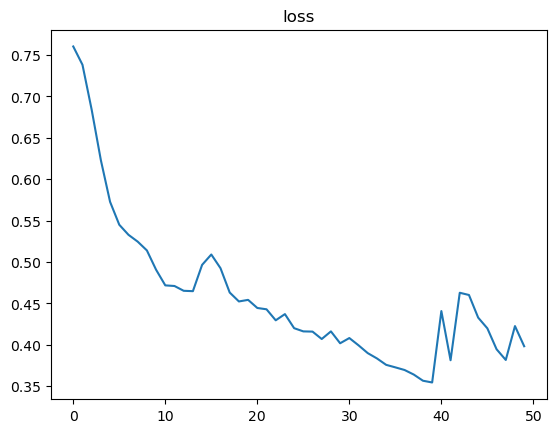

In [378]:
plt.plot(history)
plt.title('loss')
plt.show()

In [340]:
y_train_pred = model(torch.tensor(X_train,dtype=torch.float))
y_test_pred = model(torch.tensor(X_test,dtype=torch.float))

#convert to numpy array
y_train_pred = y_train_pred.detach().numpy()
y_test_pred = y_test_pred.detach().numpy()

In [341]:
test_metric_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
train_metric_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
print('train rmse', round(train_metric_rmse, 3))
print('test rmse', round(test_metric_rmse, 3))

train rmse 0.277
test rmse 0.345


In [342]:
test_metric_r2_score = r2_score(y_test, y_test_pred)
train_metric_r2_score = r2_score(y_train, y_train_pred)
print('train r2_score', round(train_metric_r2_score, 3))
print('test r2_score', round(train_metric_r2_score, 3))

train r2_score 0.926
test r2_score 0.926


In [343]:
task_params = {'epoches': 50, 'batch_size': 32, 'test_rmse' : test_metric_rmse, 'train_rmse' : train_metric_rmse,
               'test_r2_score' : test_metric_r2_score, 'train_r2_score' : train_metric_r2_score}

task_params = task.connect(task_params)

In [344]:
torch.save(model.state_dict(), '../models/takeoff_CFM56-7.pt')

In [345]:
task.close()

In [ ]:
for filename in os.listdir("../data/grouped/"):
    if (".csv" in filename):
        df = pd.read_csv("../data/grouped/" + filename)       
        to_categorical = ['number_blades', 'engine_position', 'engine_type', 
                          'manufacturer', 'aircraft_family', 'aircraft_type', 'aircraft_grp',
                          'ac_manufacturer', 'n1_modifier', 'IAI', 'ZVB2F', 'ZVB2R', 'IBE', 'IVS12', 'IAIE']
        numerical = list(set(df.columns.to_list()) - set(to_categorical))
        df = preprocess_file(df, corr_ther = 0.95)
        
        for cl in targets:
            X = df[features].values
            y = df[cl].values
            y = y.reshape(y.shape[0], 1)
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
            training_set = MyDataset(X_train, y_train)
            training_loader = torch.utils.data.DataLoader(training_set, batch_size = 32)
            val_set = MyDataset(X_test, y_test)
            val_loader = torch.utils.data.DataLoader(val_set, batch_size = 32)
            
            task = Task.init(project_name='SkyRulers',
                 task_name=f'LinearModel_30ep_{filename + '_' + cl}')
            
                model = NN()
                optimizer = optim.SGD(model.parameters(), lr=1e-2)
                loss_fn = nn.MSELoss()
                epochs=40
                history = []

                for i in range(epochs):
                    loss_sum = 0
                    loss_count = 0
                    for x_batch, y_batch in training_loader:
                        #initialize the model parameter
                        optimizer.zero_grad()
                        #calculate the loss
                        output = model.forward(x_batch)
                        loss = loss_fn(output, y_batch)
                        loss_sum += math.sqrt(loss.detach().numpy())
                        loss_count += 1
                        #backpropagation
                        loss.backward()
                        #update the parameters
                        optimizer.step()
                    if(i % 10 == 0):
                        print(f"epochs: {i}......loss:{loss_sum / loss_count}")
                    history.append(loss_sum / loss_count)
                    
                    plt.plot(history)
                    plt.title('loss')
                    plt.show()
                    
                    y_train_pred = model(torch.tensor(X_train,dtype=torch.float))
                    y_test_pred = model(torch.tensor(X_test,dtype=torch.float))
                    #convert to numpy array
                    y_train_pred = y_train_pred.detach().numpy()
                    y_test_pred = y_test_pred.detach().numpy()
                    
                    test_metric_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
                    train_metric_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
                    
                    test_metric_r2_score = r2_score(y_test, y_test_pred)
                    train_metric_r2_score = r2_score(y_train, y_train_pred)
                    
                    task_params = {'epoches': 50, 'batch_size': 32, 'test_rmse' : test_metric_rmse, 'train_rmse' : train_metric_rmse,
                       'test_r2_score' : test_metric_r2_score, 'train_r2_score' : train_metric_r2_score}
                    task_params = task.connect(task_params)
                    torch.save(model.state_dict(), f'../models/{filename + '_' + cl}.pt')
                    task.close()